## Introduction

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import re
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#read the file 
df = pd.read_csv('text_emotion3.csv')

df = df[['content','sentiment']]

df.head(10)

,content,sentiment
0,Layin n bed with a headache ughhhh...waitin o...,sadness
1,Funeral ceremony...gloomy friday...,sadness
2,"I should be sleep, but im not! thinking about ...",sadness
3,@charviray Charlene my love. I miss you,sadness
4,@kelcouch I'm sorry at least it's Friday?,sadness
5,Ugh! I have to beat this stupid song to get to...,sadness
6,@BrodyJenner if u watch the hills in london u ...,sadness
7,The storm is here and the electricity is gone,sadness
8,So sleepy again and it's not even that late. I...,sadness
9,How are YOU convinced that I have always wante...,sadness


In [ ]:
df.shape

(10374, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10374 entries, 0 to 10373
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    10374 non-null  object
 1   sentiment  10374 non-null  object
dtypes: object(2)
memory usage: 162.2+ KB


In [ ]:
df.index = range(10374)
df['content'].apply(lambda x: len(x.split(' '))).sum()

146203

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


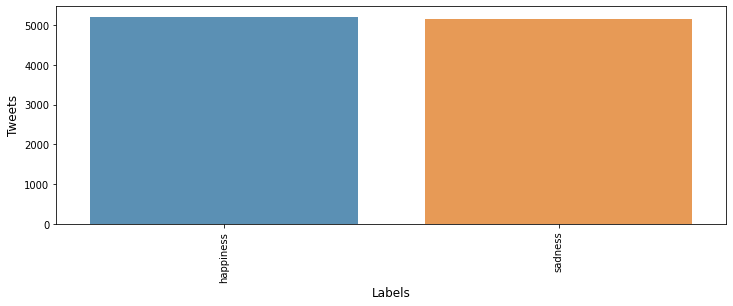

In [ ]:
# visualising data distribution happiness vs sadness

count1 = df['sentiment'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(count1.index, count1.values, alpha=0.8)
plt.ylabel('Tweets', fontsize=12)

plt.xlabel('Labels', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [ ]:
def print_contentSenti(index):
    
    example = df[df.index == index][['content', 'sentiment']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Sentiment:', example[1])
        
print_contentSenti(12)

Fudge.... Just BS'd that whole paper.... So tired.... Ugh I hate school.....  time to sleep!!!!!!!!!!!
Sentiment: sadness


## Pre-processing

In [ ]:
from bs4 import BeautifulSoup

def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    text = text.replace('@', '')
    # text = text.replace('.', '')
    text = re.sub('[!@#$]', ' ', text)
    text = re.sub('[...]', ' ', text)
    text = re.sub(' +', ' ', text)
    return text

df['content'] = df['content'].apply(cleanText)

In [ ]:
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords

train, test = train_test_split(df, test_size=0.2, random_state=42)

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

train_tagged = train.apply(lambda r: TaggedDocument(words=tokenize_text(r['content']), tags=[r.sentiment]), axis=1)
test_tagged = test.apply(lambda r: TaggedDocument(words=tokenize_text(r['content']), tags=[r.sentiment]), axis=1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Feature - Doc2Vec

In [ ]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [ ]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 8299/8299 [00:00<00:00, 1441645.43it/s]


In [ ]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 8299/8299 [00:00<00:00, 2466590.77it/s]


CPU times: user 18.7 s, sys: 2.42 s, total: 21.1 s
Wall time: 13.3 s


In [ ]:
# Building the Final Vector Feature for the Classifier
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Training and testing datasets
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

# NB classifier
from sklearn.naive_bayes import GaussianNB
cNB = GaussianNB()
cNB.fit(X_train, y_train) 
yd_pred_NB = cNB.predict(X_test)
print('Testing accuracy NB %s' % accuracy_score(y_test, yd_pred_NB))
print('Testing F1 score NB (DOC2VEC): {}'.format(f1_score(y_test, yd_pred_NB, average='macro')))
print('Testing Precision score NB (DOC2VEC): {}'.format(precision_score(y_test, yd_pred_NB, average='macro')))
print('Testing Recall score NB(DOC2VEC): {}'.format(recall_score(y_test, yd_pred_NB, average='macro')))

Testing accuracy NB 0.5373493975903615
Testing F1 score NB (DOC2VEC): 0.4623481781376518
Testing Precision score NB (DOC2VEC): 0.562212094482015
Testing Recall score NB(DOC2VEC): 0.529498559345664


## Feature - BOW

In [ ]:
# Splitting training and testing datasets
from sklearn.model_selection import train_test_split

sentences = df['content'].values
y = df['sentiment'].values
sentences_train, sentences_test, yy_train, yy_test = train_test_split(sentences,y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

BOW = CountVectorizer()
BOW.fit(sentences_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

XX_train = BOW.transform(sentences_train)
XX_test  = BOW.transform(sentences_test)

# NB classifier
from sklearn.naive_bayes import MultinomialNB
cNB = MultinomialNB()
cNB.fit(XX_train, yy_train) 
yb_pred_NB = cNB.predict(XX_test)
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
print('Testing F1 score NB (BOW): {}'.format(f1_score(yy_test, yb_pred_NB, average='macro')))
print('Testing Precision score NB (BOW): {}'.format(precision_score(yy_test, yb_pred_NB, average='macro')))
print('Testing Recall score NB (BOW): {}'.format(recall_score(yy_test, yb_pred_NB, average='macro')))

Testing F1 score NB (BOW): 0.790715572336045
Testing Precision score NB (BOW): 0.7925670818685207
Testing Recall score NB (BOW): 0.7905265359234129


## Feature TF-IDF

In [ ]:
# Spliting training and testing datasets
from sklearn.model_selection import train_test_split

sentences = df['content'].values
y = df['sentiment'].values
sentences_train, sentences_test, yyy_train, yyy_test = train_test_split(sentences,y, test_size=0.2, random_state=42)

from sklearn.feature_extraction.text import TfidfVectorizer
TFIDF = TfidfVectorizer()
TFIDF.fit(sentences_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score,precision_score, recall_score

XXX_train = TFIDF.transform(sentences_train)
XXX_test  = TFIDF.transform(sentences_test)

# NB classifier
from sklearn.naive_bayes import MultinomialNB
cNB = MultinomialNB()
cNB.fit(XXX_train, yyy_train) 
ytf_pred_NB = cNB.predict(XXX_test)
print('Testing accuracy NB %s' % accuracy_score(yyy_test, ytf_pred_NB))
print('Testing F1 score NB (TFIDF): {}'.format(f1_score(yyy_test,ytf_pred_NB, average='macro')))
print('Testing Precision score NB (TFIDF): {}'.format(precision_score(yyy_test, ytf_pred_NB, average='macro')))
print('Testing Recall score NB (TFIDF): {}'.format(recall_score(yyy_test, ytf_pred_NB, average='macro')))

Testing accuracy NB 0.788433734939759
Testing F1 score NB (TFIDF): 0.7877237851662404
Testing Precision score NB (TFIDF): 0.7899756303308652
Testing Recall score NB (TFIDF): 0.7875499581745515


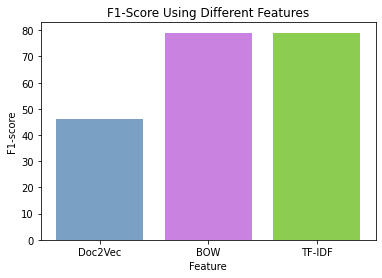

In [ ]:
docNB = f1_score(yy_test, yd_pred_NB, average='macro')*100
bowNB = f1_score(yy_test, yb_pred_NB, average='macro')*100
tfNB = f1_score(yy_test, ytf_pred_NB, average='macro')*100

bars = ('Doc2Vec', 'BOW', 'TF-IDF')
result = [docNB, bowNB, tfNB]
y_pos = np.arange(len(bars))

plt.bar(y_pos, result, color=("#7aa0c4", "#ca82e1", "#8bcd50"))

plt.rcParams['axes.facecolor'] = 'white'

plt.title('F1-Score Using Different Features')
plt.xlabel('Feature')
plt.ylabel('F1-score')
plt.xticks(y_pos, bars)

plt.show()

## Conclusion

F1-scores for BOW and TF-IDF are almost comparable. The differences are very small. Thus, a model with feature BOW is selected as it produced the best result.

## Credits

1) Sabrina Tiun. (2020).